In [2]:
# Check the version of tensorflow
import tensorflow as tf

print("TensorFlow version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))


TensorFlow version: 2.10.1
GPU Available: []


In [1]:
# local imports
import voxelmorph as vxm
import neurite as ne
import os
import numpy as np
import re
import sys
import os
import numpy as np
import random
import shutil
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger
import keras.backend as K


In [4]:
base_path = os.getcwd()
data_path = 'D:\study\graduation project\GP-2025-Strain\Data\ACDC\database'
training_data_path = os.path.join(data_path, 'processed_training')
# testing_data_path = os.path.join(data_path, 'processed_testing')

In [5]:
def create_radial_mask(shape=(512, 512), center_weight=1.0, edge_weight=0.1):
    """Create a radial mask with highest values in the center"""
    y, x = np.ogrid[:shape[0], :shape[1]]
    center = (shape[0]//2, shape[1]//2)

    # Calculate distances from center
    dist_from_center = np.sqrt((x - center[1])**2 + (y - center[0])**2)

    # Normalize distances to [0, 1]
    max_dist = np.sqrt((shape[0]//2)**2 + (shape[1]//2)**2)
    normalized_dist = dist_from_center / max_dist

    # Create weight mask that transitions from center_weight to edge_weight
    mask = center_weight - (center_weight - edge_weight) * normalized_dist
    return mask.astype(np.float32)


In [6]:
def load_sample_data(data_path, patient_num, time_frame, slice_num):
    """Load a single slice of data, return None if not found"""
    filename = f"patient{patient_num:03d}_t{time_frame:02d}_z{slice_num:02d}.npy"
    filepath = os.path.join(data_path, filename)

    if os.path.exists(filepath):
        return np.load(filepath)
    else:
        return None  # Return None if the file doesn't exist

In [ ]:
def find_patient_folders(root_dir):
    """Find all patient folders across multiple data directories"""
    patient_folders = []
    
    # Iterate through main data folders (folder1, folder2, folder3)
    for main_folder in os.listdir(root_dir):
        main_path = os.path.join(root_dir, main_folder)
        if not os.path.isdir(main_path):
            continue
            
        # Find patient subfolders
        for patient_folder in os.listdir(main_path):
            if patient_folder.startswith("patient") and os.path.isdir(os.path.join(main_path, patient_folder)):
                patient_folders.append(os.path.join(main_path, patient_folder))
    
    return patient_folders

In [7]:
def prepare_dataset(data_path, max_patients=100, max_slices=10, max_frames=30):
    """
    Prepare dataset from multiple patients and slices, handling missing data.
    Returns: List of (moving, fixed) pairs
    """
    all_pairs = []

    # Iterate through patients
    for patient in range(1, max_patients + 1):
        patient_has_data = False  # Track if the patient has at least one valid frame

        for slice_num in range(max_slices):
            frames = []

            for t in range(max_frames - 1):  # Check up to max_frames - 1
                frame1 = load_sample_data(data_path, patient, t, slice_num)
                frame2 = load_sample_data(data_path, patient, t + 1, slice_num)

                if frame1 is not None and frame2 is not None:
                    # Add channel dimension required by VoxelMorph
                    frame1 = frame1[..., np.newaxis]
                    frame2 = frame2[..., np.newaxis]
                    frames.append((frame1, frame2))
                    patient_has_data = True

            if frames:  # If we found valid frames for this slice, add them
                all_pairs.extend(frames)

        if not patient_has_data:
            print(f"Skipping patient {patient} (no valid data found)")

    if not all_pairs:
        raise ValueError("No valid data found in the dataset.")

    # Convert to numpy arrays
    moving_images = np.stack([pair[0] for pair in all_pairs])
    fixed_images = np.stack([pair[1] for pair in all_pairs])

    return moving_images, fixed_images

moving_images, fixed_images = prepare_dataset(training_data_path, max_patients=100, max_slices=10, max_frames=30)

Skipping patient 11 (no valid data found)
Skipping patient 12 (no valid data found)
Skipping patient 13 (no valid data found)
Skipping patient 14 (no valid data found)
Skipping patient 15 (no valid data found)
Skipping patient 16 (no valid data found)
Skipping patient 17 (no valid data found)
Skipping patient 18 (no valid data found)
Skipping patient 19 (no valid data found)
Skipping patient 20 (no valid data found)
Skipping patient 21 (no valid data found)
Skipping patient 22 (no valid data found)
Skipping patient 23 (no valid data found)
Skipping patient 24 (no valid data found)
Skipping patient 25 (no valid data found)
Skipping patient 26 (no valid data found)
Skipping patient 27 (no valid data found)
Skipping patient 28 (no valid data found)
Skipping patient 29 (no valid data found)
Skipping patient 30 (no valid data found)
Skipping patient 31 (no valid data found)
Skipping patient 32 (no valid data found)
Skipping patient 33 (no valid data found)
Skipping patient 34 (no valid data

In [8]:
print("Moving images shape:", moving_images.shape)
print("Fixed images shape:", fixed_images.shape)

Moving images shape: (2680, 512, 512, 1)
Fixed images shape: (2680, 512, 512, 1)


In [9]:
print("Moving images shape:", moving_images.shape[1:3])

Moving images shape: (512, 512)


In [10]:
# Generate mock mask data for all fixed images
mask_data = np.array([create_radial_mask(shape=fixed_images.shape[1:3]) for _ in range(fixed_images.shape[0])])
mask_data = mask_data[..., np.newaxis]  # Ensure shape (2680, 512, 512, 1)
print("Mask data shape:", mask_data.shape)  # Should match fixed_images shape

Mask data shape: (2680, 512, 512, 1)


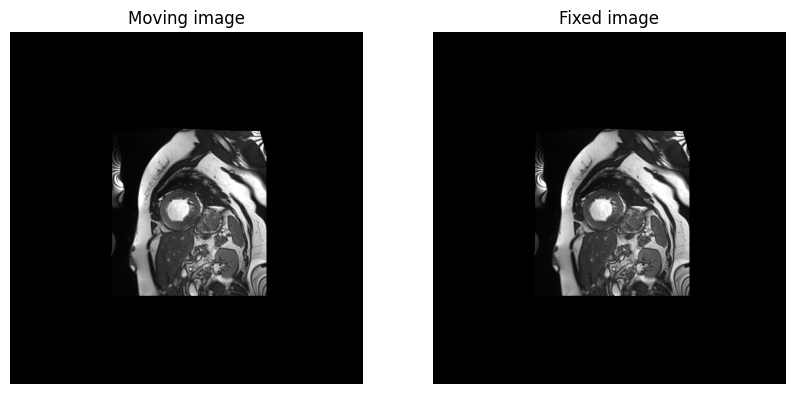

In [11]:
# Visualize moving and fixed images of a random sample (same slice)
sample_idx = np.random.randint(moving_images.shape[0])
sample_moving = moving_images[sample_idx, ..., 0]
sample_fixed = fixed_images[sample_idx, ..., 0]

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(sample_moving, cmap='gray')
plt.title("Moving image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(sample_fixed, cmap='gray')
plt.title("Fixed image")
plt.axis('off')

plt.show()

In [16]:
def vxm_data_generator(moving_image, fixed_image, mask_data, batch_size=8):
    """
    Generator that yields:
    - Inputs: [moving_image, fixed_image]  (No separate mask input)
    - Outputs: [fixed_images_with_mask, zero_phi]  (Mask included in y_true)
    """
    vol_shape = moving_image.shape[1:]  # (512, 512, 1)
    
    zero_phi = np.zeros((batch_size, vol_shape[0], vol_shape[1], 2))  # (batch_size, 512, 512, 2)

    while True:
        # Randomly select batch indices
        idx1 = np.random.randint(0, moving_image.shape[0], size=batch_size)

        # Prepare inputs
        moving_images = moving_image[idx1]  # (batch_size, 512, 512, 1)
        fixed_images = fixed_image[idx1]  # (batch_size, 512, 512, 1)
        masks = mask_data[idx1]  # (batch_size, 512, 512, 1)

        # Concatenate mask with fixed image in y_true
        fixed_images_with_mask = np.concatenate([fixed_images, masks], axis=-1)  # (batch_size, 512, 512, 2)

        yield (
            [moving_images, fixed_images],  # Inputs
            [fixed_images_with_mask, zero_phi]  # Outputs
        )


In [3]:
class LazyDataGenerator:
    def __init__(self, data_paths, batch_size=8, max_slices=10, max_frames=30, frame_skip=1, shuffle=True, split_ratio=0.8):
        """
        A generator that loads ACDC data dynamically instead of preloading everything.

        Parameters:
        - data_paths (list): List of dataset directories containing patientXXX folders.
        - batch_size (int): Number of samples per batch.
        - max_slices (int): Max slices per patient to consider.
        - max_frames (int): Max time frames per slice.
        - frame_skip (int): Number of frames to skip when pairing (1 = next frame, 2 = skip one, etc.).
        - shuffle (bool): Whether to shuffle patient and slice order.
        - split_ratio (float): Ratio for training set (e.g., 0.8 means 80% training, 20% testing).
        """
        self.data_paths = data_paths  
        self.batch_size = batch_size
        self.max_slices = max_slices
        self.max_frames = max_frames
        self.frame_skip = frame_skip  # How many frames to skip before pairing
        self.shuffle = shuffle

        # Collect all patient folders from all dataset parts
        self.patient_folders = []
        for path in data_paths:
            self.patient_folders.extend(
                [os.path.join(path, f) for f in os.listdir(path) if f.startswith("patient") and os.path.isdir(os.path.join(path, f))]
            )

        if self.shuffle:
            random.shuffle(self.patient_folders)

        # Split into training and testing
        split_index = int(len(self.patient_folders) * split_ratio)
        self.train_patients = self.patient_folders[:split_index]
        self.test_patients = self.patient_folders[split_index:]

    def load_sample_data(self, patient_path, patient_num, time_frame, slice_num):
        """Loads a single slice of data, or returns None if not found."""
        filename = f"patient{patient_num:03d}_t{time_frame:02d}_z{slice_num:02d}.npy"
        filepath = os.path.join(patient_path, filename)

        if os.path.exists(filepath):
            return np.load(filepath)
        return None

    def get_generator(self, mode="train"):
        """
        Returns a generator for training or testing.
        - mode="train" -> Uses training set
        - mode="test" -> Uses testing set
        """
        patients = self.train_patients if mode == "train" else self.test_patients

        while True:
            if self.shuffle:
                random.shuffle(patients)

            batch_moving = []
            batch_fixed = []
            batch_masks = []

            for patient_folder in patients:
                patient_num = int(patient_folder.split("patient")[-1])  # Extract patient ID
                
                for slice_num in range(self.max_slices):
                    for t in range(self.max_frames - self.frame_skip):  # Ensure we don't exceed available frames
                        frame1 = self.load_sample_data(patient_folder, patient_num, t, slice_num)
                        frame2 = self.load_sample_data(patient_folder, patient_num, t + self.frame_skip, slice_num)

                        if frame1 is not None and frame2 is not None:
                            # Add channel dimension
                            frame1 = frame1[..., np.newaxis]
                            frame2 = frame2[..., np.newaxis]

                            # Generate mask (replace with actual mask loading if available)
                            mask = create_radial_mask(shape=frame1.shape[:2])

                            batch_moving.append(frame1)
                            batch_fixed.append(frame2)
                            batch_masks.append(mask)

                            # Yield batch when full
                            if len(batch_moving) == self.batch_size:
                                moving_images = np.stack(batch_moving)
                                fixed_images = np.stack(batch_fixed)
                                masks = np.stack(batch_masks)

                                batch_moving, batch_fixed, batch_masks = [], [], []

                                # Prepare outputs
                                fixed_images_with_mask = np.concatenate([fixed_images, masks], axis=-1)
                                zero_phi = np.zeros((self.batch_size, fixed_images.shape[1], fixed_images.shape[2], 2))

                                yield ([moving_images, fixed_images], [fixed_images_with_mask, zero_phi])


In [4]:
def visualize_samples(generator, output_folder, num_samples=10):
    """
    Visualizes random samples from the generator and saves them as images.

    Parameters:
    - generator: Data generator to sample from.
    - output_folder: Directory where images will be saved.
    - num_samples: Number of images to save.
    """
    os.makedirs(output_folder, exist_ok=True)

    for i in range(num_samples):
        (moving, fixed), (fixed_with_mask, _) = next(generator)
        
        for j in range(moving.shape[0]):
            fig, axes = plt.subplots(1, 3, figsize=(12, 4))
            
            axes[0].imshow(moving[j, :, :, 0], cmap="gray")
            axes[0].set_title("Moving Image")

            axes[1].imshow(fixed[j, :, :, 0], cmap="gray")
            axes[1].set_title("Fixed Image")

            axes[2].imshow(fixed_with_mask[j, :, :, 0], cmap="gray")
            axes[2].set_title("Mask Image")

            # Set overall title with patient & slice info
            plt.suptitle(f"Sample {i+1}-{j+1}")
            plt.tight_layout()

            # Save the image
            save_path = os.path.join(output_folder, f"sample_{i+1}_{j+1}.png")
            plt.savefig(save_path)
            plt.close(fig)
            print(f"Saved visualization: {save_path}")

In [17]:
def weighted_mse_loss(y_true, y_pred):
    """
    Custom loss function that weights the MSE loss by a segmentation mask.
    The last channel of y_true is assumed to be the mask.
    """
    squared_diff = K.square(y_true[..., :-1] - y_pred)  # Ignore last channel for loss
    mask = y_true[..., -1:]  # Extract mask from last channel
    weighted_diff = squared_diff * mask
    return K.mean(weighted_diff)

In [18]:
from voxelmorph.tf.networks import VxmDense

# Define the input shapes
inshape = moving_images.shape[1:3]  # (512, 512)
nb_features = [
    [32, 32, 32, 32],         # encoder features
    [32, 32, 32, 32, 32, 16]  # decoder features
]

# Inputs
moving_image = tf.keras.Input(shape=(*inshape, 1), name='moving_image')
fixed_image = tf.keras.Input(shape=(*inshape, 1), name='fixed_image')

# Build the VoxelMorph model
vxm_model = VxmDense(inshape, nb_features, int_steps=0)
moved_image, disp = vxm_model([moving_image, fixed_image])

# Final model with two inputs (mask is embedded in y_true)
model = tf.keras.Model(
    inputs=[moving_image, fixed_image],
    outputs=[moved_image, disp]
)


In [19]:
lambda_param = 0.05
loss_weights = [1, lambda_param]

model.compile(
    optimizer='Adam',
    loss=[weighted_mse_loss, vxm.losses.Grad('l2').loss],  # Use fixed loss function
    loss_weights=loss_weights
)


In [20]:
# # Assuming x_train and mask_data are prepared
# batch_size = 8
# train_generator = vxm_data_generator(moving_images, fixed_images, mask_data, batch_size=batch_size)

In [21]:
# sample_batch = next(iter(train_generator))
# print("Sample batch shapes:", [[arr.shape for arr in sublist] for sublist in sample_batch])

Sample batch shapes: [[(8, 512, 512, 1), (8, 512, 512, 1)], [(8, 512, 512, 2), (8, 512, 512, 2)]]


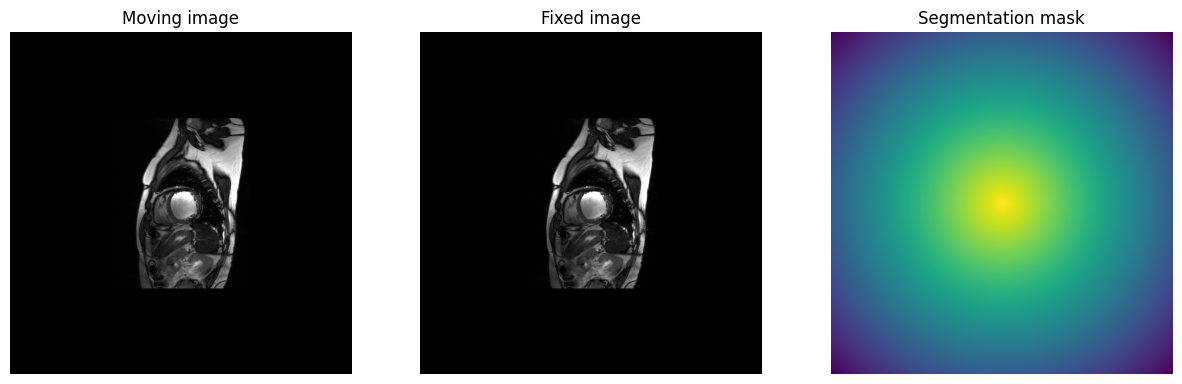

In [23]:
# # Visualize a sample batch from the generator
# sample_idx = np.random.randint(batch_size)
# sample_moving = sample_batch[0][0][sample_idx, ..., 0]
# sample_fixed = sample_batch[0][1][sample_idx, ..., 0]
# sample_mask = sample_batch[1][0][sample_idx, ..., 1]  # Mask is the last channel

# plt.figure(figsize=(15, 5))
# plt.subplot(1, 3, 1)
# plt.imshow(sample_moving, cmap='gray')
# plt.title("Moving image")
# plt.axis('off')

# plt.subplot(1, 3, 2)
# plt.imshow(sample_fixed, cmap='gray')
# plt.title("Fixed image")
# plt.axis('off')

# plt.subplot(1, 3, 3)
# plt.imshow(sample_mask, cmap='viridis')
# plt.title("Segmentation mask")
# plt.axis('off')

# plt.show()

In [ ]:
# Define dataset folder paths
data_folders = [
    "D:/study/graduation project/GP-2025-Strain/Data/ACDC/database/part1",
    "D:/study/graduation project/GP-2025-Strain/Data/ACDC/database/part2",
    "D:/study/graduation project/GP-2025-Strain/Data/ACDC/database/part3",
]

# Create generator
batch_size = 8
frame_skip = 2  # Change to 1 for direct next frame, 2 to skip one frame, etc.
split_ratio = 0.8  # 80% training, 20% testing

data_generator = LazyDataGenerator(data_paths=data_folders, batch_size=batch_size, frame_skip=frame_skip, split_ratio=split_ratio)

# Get train and test generators
train_generator = data_generator.get_generator(mode="train")
# test_generator = data_generator.get_generator(mode="test")

In [ ]:
# Usage Example
visualization_path = "D:/study/graduation project/GP-2025-Strain/visualization"
visualize_samples(train_generator, visualization_path, num_samples=10)

In [24]:
print(model)


In [25]:
model.fit(
    x=train_generator,
    steps_per_epoch=100,
    epochs=2,
    verbose=1
)


Epoch 1/2
100/100 [==============================] - 1313s 13s/step - loss: 6.0072e-05 - vxm_dense_loss: 6.0026e-05 - vxm_dense_1_loss: 9.1253e-07
Epoch 2/2
100/100 [==============================] - 1178s 12s/step - loss: 6.1433e-05 - vxm_dense_loss: 6.1267e-05 - vxm_dense_1_loss: 3.3134e-06


1/1 [==============================] - 0s 221ms/step


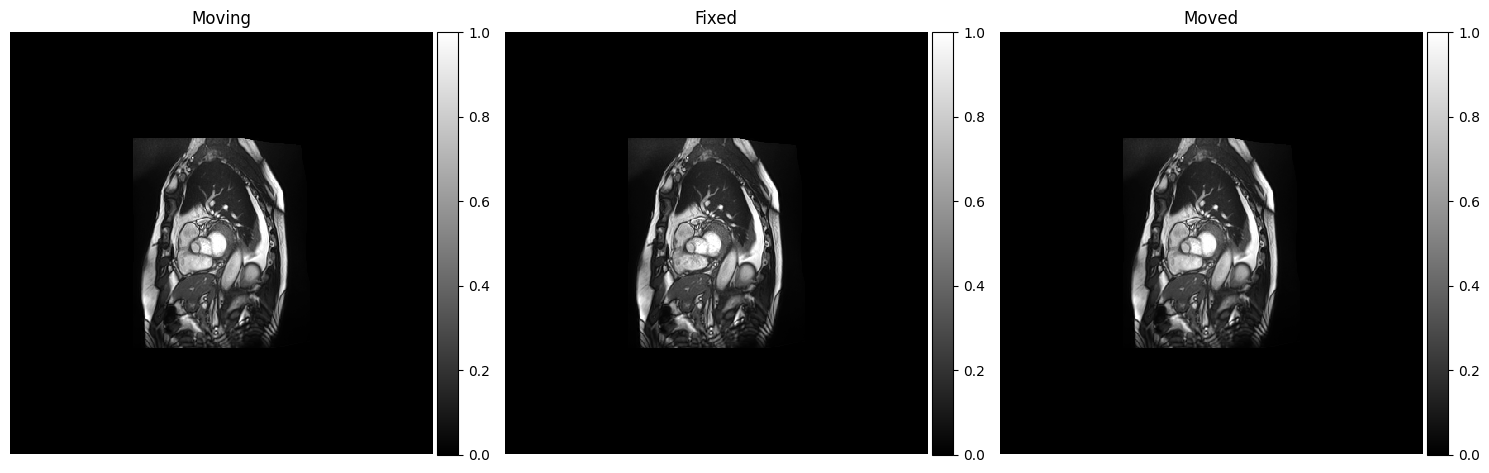

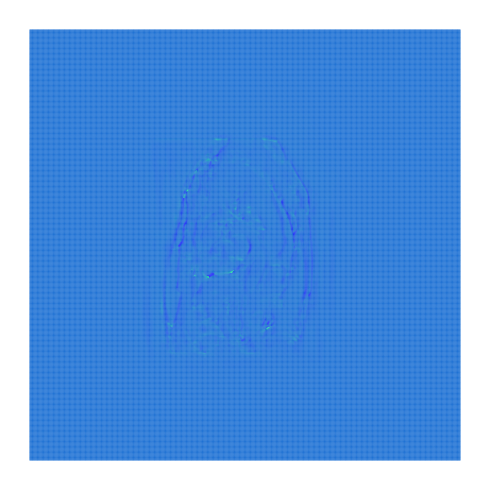

In [28]:
# Visualize the results of the trained model using neurite
# Load a sample moving image
sample_moving = moving_images[0][..., 0]  # (512, 512)

# Predict the transformation
moved_image, displacement = model.predict([sample_moving[np.newaxis, ..., np.newaxis], fixed_images[0][np.newaxis, ..., np.newaxis]])

# Convert to numpy arrays
moved_image = moved_image[0, ..., 0]
displacement = displacement[0]

# Visualize the results
ne.plot.slices([sample_moving, fixed_images[0, ..., 0], moved_image], cmaps=['gray', 'gray', 'gray'], do_colorbars=True, titles=['Moving', 'Fixed', 'Moved'])
ne.plot.flow([displacement.squeeze()], width=5, scale=10)

plt.show()